In [1]:
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import nltk
import string

# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
# bearer_token = os.environ.get("BEARER_TOKEN")
bearer_token ='AAAAAAAAAAAAAAAAAAAAACqHUgEAAAAAcghJSkKBmFmw36ZiRxrqVdyomIk%3DZlDqMjNA0ka4btIuhDjiHUyRGoCHDzKBWvNGcqYXpLJ5kuhUAp'

In [2]:
def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# 1. Collecting data: 
In this assignment you need to collect data related to stock market from Twitter for one week. In Twitter, ticker symbols like #gold are used for stocks and companies. You are requested to collect the tweets with some specific keywords and store them in different files. The following keywords should be used:  
* Altcoin  
* Bitcoin  
* Coindesk  
* Cryptocurrency  
* Gold  
* APPL  
* GOOG  
* YHOO

Each tweet is a json file with the following format:  
```
{"created_at":”..........”,  
"id":”...........”,  
"text":" Time to buy some ether!\n#ethereum #investing #cryptocurrency”  
“user_id”:”...........”  
...  
}
```

In [3]:
dates = [
    datetime.datetime(2021,10,13),
    datetime.datetime(2021,10,14),
    datetime.datetime(2021,10,15),
    datetime.datetime(2021,10,16),
    datetime.datetime(2021,10,17),
    datetime.datetime(2021,10,18),
    datetime.datetime(2021,10,19),
]
keywords = ['altcoin', 'bitcoin', 'coindesk', 'cryptocurrency', 'gold', 'APPL', 'GOOG', 'YHOO']

In [4]:
class Scrapper:
    def __init__(self, keyword):
        self.keyword = keyword
        # Creates the dataframe for the keyword
        self.dataframe = pd.DataFrame()
    
    def file_name(self):
        return f'data/tweets_{self.keyword}.csv'

    def check_file_existence(self):
        return os.path.exists(self.file_name())
    
    def get_tweets(self, from_date):
        to_date = from_date + datetime.timedelta(days=1)
        search_url = "https://api.twitter.com/2/tweets/search/recent"
        query_params = {
            'query': self.keyword, 
            'start_time': from_date.isoformat("T") + "Z", 
            'end_time': to_date.isoformat("T") + "Z",
            'tweet.fields': 'author_id,created_at,geo', 
            'max_results': 100}
        print(query_params)
        # Queries Twitter to get the keyword related tweets
        json_response = connect_to_endpoint(search_url, query_params)
        # Convert the response to a dataframe
        df = pd.DataFrame(json_response['data']) 
        df['Keyword'] = self.keyword
        # Appends the results to the planned day dataframe
        self.dataframe = self.dataframe.append(df, ignore_index=True)
       
    def save(self):
        print(f'Saving {self.file_name()}')
        self.dataframe.to_csv(self.file_name())
        
    def load(self):
        print(f'Loading {self.file_name()}')
        self.dataframe = pd.read_csv(self.file_name())
    

# 2. Saving data: 
You need to save the requested data into csv format of 8 files where data related to each keyword is saved. Each file consist of four columns: 
* tweet id
* time of tweet
* user id
* text.

In [5]:
# Executes the planned queries for each keyword
for keyword in keywords:
    scrapper = Scrapper(keyword)
    if scrapper.check_file_existence():
        # If the file already exists ommits the query to twitter API
        print(f'File {scrapper.file_name()} already exists.. skipping query to twitter API')
        continue
    # Gets tweet for each date
    for date in dates:
        scrapper.get_tweets(date)
    # Saves the file
    scrapper.save()       
        

File data/tweets_altcoin.csv already exists.. skipping query to twitter API
File data/tweets_bitcoin.csv already exists.. skipping query to twitter API
File data/tweets_coindesk.csv already exists.. skipping query to twitter API
File data/tweets_cryptocurrency.csv already exists.. skipping query to twitter API
File data/tweets_gold.csv already exists.. skipping query to twitter API
File data/tweets_APPL.csv already exists.. skipping query to twitter API
File data/tweets_GOOG.csv already exists.. skipping query to twitter API
File data/tweets_YHOO.csv already exists.. skipping query to twitter API


# 3. Cleaning data: 
remove duplication, remove punctuations, remove numbers in tweets, and remove words with length less than 2.

In [6]:
# Reads the tweets csv files and consolidates them in a single dataframe
complete_df = pd.DataFrame() 
for keyword in keywords:
    scrapper = Scrapper(keyword)
    # Loads the data from its corresponding CSV file
    scrapper.load()
    # Merges the data in a single dataframe
    complete_df = complete_df.append(scrapper.dataframe, ignore_index=True)

Loading data/tweets_altcoin.csv
Loading data/tweets_bitcoin.csv
Loading data/tweets_coindesk.csv
Loading data/tweets_cryptocurrency.csv
Loading data/tweets_gold.csv
Loading data/tweets_APPL.csv
Loading data/tweets_GOOG.csv
Loading data/tweets_YHOO.csv


In [7]:
complete_df.head(10)

,Unnamed: 0,created_at,author_id,text,id,Keyword,geo
0,0,2021-10-14T12:59:59.000Z,1383414078274609159,RT @StancaAndrei96: @DjPrestigeUk @CryptoIslan...,1448634693667151876,altcoin,NaN
1,1,2021-10-14T12:59:59.000Z,1285696456985399297,RT @MeditationWhy: KAILASA's Navaratri 2021\nK...,1448634690412466184,altcoin,NaN
2,2,2021-10-14T12:59:57.000Z,2857047351,RT @TheMoonCarl: Altcoin season soon?,1448634684108271619,altcoin,NaN
3,3,2021-10-14T12:59:56.000Z,1383414078274609159,RT @StancaAndrei96: @DjPrestigeUk @CryptoIslan...,1448634679821848582,altcoin,NaN
4,4,2021-10-14T12:59:56.000Z,1386010952584343553,RT @Kust121090: $NFTART Is blowing up! Check t...,1448634678446014466,altcoin,NaN
5,5,2021-10-14T12:59:55.000Z,1437167848863019011,RT @koinefendisi: #kishu $kishu @InuKishu @Kis...,1448634675988205570,altcoin,NaN
6,6,2021-10-14T12:59:54.000Z,1432280355885633540,@abu_crypto1 https://t.co/KsGzzDB9Wc Morgan St...,1448634670858395654,altcoin,NaN
7,7,2021-10-14T12:59:53.000Z,1447208551395430400,@gate_io @elonmusk @gate_io Buff Doge Coin to...,1448634667679162375,altcoin,NaN
8,8,2021-10-14T12:59:53.000Z,1285696456985399297,RT @MeditationWhy: KAILASA's Navaratri 2021\nK...,1448634667071119362,altcoin,NaN
9,9,2021-10-14T12:59:52.000Z,1285696456985399297,RT @MeditationWhy: KAILASA's Navaratri 2021\nK...,1448634660368658457,altcoin,NaN


In [8]:
def clean_data(text):
    # Remove numbers
    text = re.sub(r'[0-9]+', '', text)
    # remove all words with a length less than 2
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # remove all citations to twitter users
    text = re.sub(r'\@\w+\b', '', text)
    # Remove punctuation
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    return text

def clean(dataframe_to_clean):
    dataframe_to_clean['text'] = dataframe_to_clean['text'].apply(lambda x: clean_data(x)) 
    return dataframe_to_clean

In [9]:
clean_df = clean(complete_df)

In [10]:
clean_df.head(10)

,Unnamed: 0,created_at,author_id,text,id,Keyword,geo
0,0,2021-10-14T12:59:59.000Z,1383414078274609159,cislaarmy cisla cislax altcoin bscgems htt...,1448634693667151876,altcoin,NaN
1,1,2021-10-14T12:59:59.000Z,1285696456985399297,kailasa navaratri \nkailasa sph jgm nithyana...,1448634690412466184,altcoin,NaN
2,2,2021-10-14T12:59:57.000Z,2857047351,altcoin season soon,1448634684108271619,altcoin,NaN
3,3,2021-10-14T12:59:56.000Z,1383414078274609159,cisla cislaarmy cislax altcoin bscgems htt...,1448634679821848582,altcoin,NaN
4,4,2021-10-14T12:59:56.000Z,1386010952584343553,nftart blowing check the stats trending h...,1448634678446014466,altcoin,NaN
5,5,2021-10-14T12:59:55.000Z,1437167848863019011,kishu kishu \n🔥🔥🔥nefessiz koşuyor🔥🔥🔥\n▶️ ◀...,1448634675988205570,altcoin,NaN
6,6,2021-10-14T12:59:54.000Z,1432280355885633540,httpsksgzzdbwc morgan stanley earnings htt...,1448634670858395654,altcoin,NaN
7,7,2021-10-14T12:59:53.000Z,1447208551395430400,buff doge coin the mars\n\nbinance bsc bu...,1448634667679162375,altcoin,NaN
8,8,2021-10-14T12:59:53.000Z,1285696456985399297,kailasa navaratri \nkailasa sph jgm nithyana...,1448634667071119362,altcoin,NaN
9,9,2021-10-14T12:59:52.000Z,1285696456985399297,kailasa navaratri \nkailasa sph jgm nithyana...,1448634660368658457,altcoin,NaN


# 4. Visualizing data: 
You need to present the daily number of tweets for each keyword as well as the daily number of users.  

In [11]:
# Adds a column with the date part of the creation date.
clean_df['created_date'] = pd.to_datetime(clean_df['created_at']).apply(lambda d: d.date())

In [56]:
def get_pivot(df, field):
    return pd.pivot_table(clean_df,
                          values= field, 
                          columns = ['Keyword'], 
                          index= ['created_date'],
                          aggfunc = lambda x: len(x.unique()))

def visualize_bars(pivot_df, custom_title):
    plot = pivot_df.plot.bar(title=custom_title, figsize=(17,5)).legend(
        loc='upper center', ncol=4, title="Keywords")
    return plot
    

In [57]:
table_per_tweets = get_pivot(clean_df, 'id')
table_per_users = get_pivot(clean_df, 'author_id')

In [58]:
# This table contains the summary by amount of tweets per day and keyword
table_per_tweets

Keyword,APPL,GOOG,YHOO,altcoin,bitcoin,coindesk,cryptocurrency,gold
created_date,,,,,,,,
2021-10-14,199,199,200,195,195,195,200,199
2021-10-15,99,100,100,100,99,100,99,100
2021-10-16,100,100,100,100,100,100,100,98
2021-10-17,100,94,100,92,100,100,100,99
2021-10-18,100,100,100,100,100,100,100,96
2021-10-19,100,100,100,100,100,99,100,100


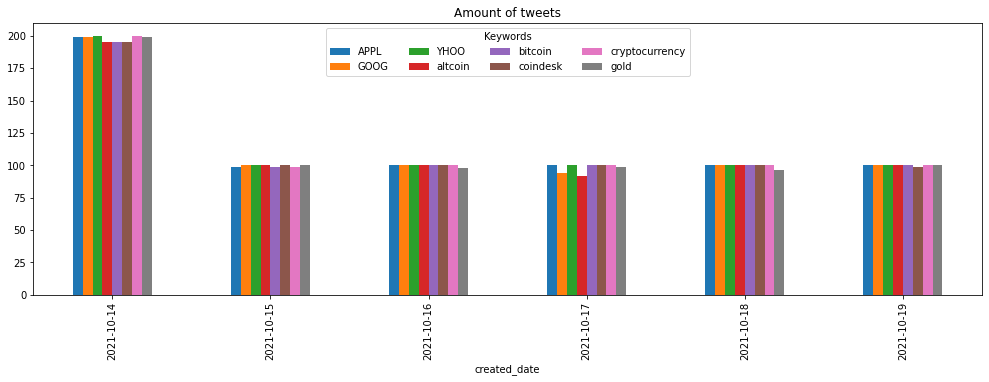

In [59]:
visualize_bars(table_per_tweets, 'Amount of tweets')

In [16]:
# This table contains the summary by amount of users per day and keyword
table_per_users

Keyword,APPL,GOOG,YHOO,altcoin,bitcoin,coindesk,cryptocurrency,gold
created_date,,,,,,,,
2021-10-14,172,181,159,170,165,150,167,191
2021-10-15,92,98,93,72,95,87,84,98
2021-10-16,87,92,87,87,79,76,79,95
2021-10-17,79,80,81,72,90,77,88,97
2021-10-18,89,91,92,89,88,63,79,90
2021-10-19,70,84,93,92,92,85,64,93


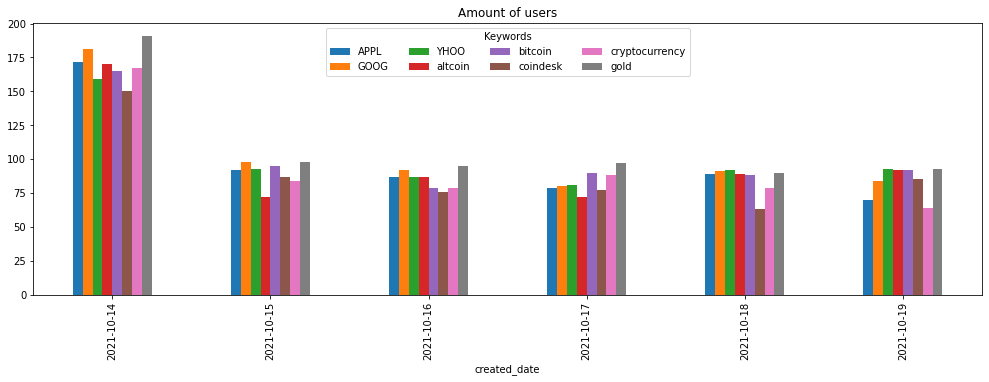

In [53]:
visualize_bars(table_per_users, 'Amount of users')